In [5]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
#from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
#from tqdm import tqdm

In [6]:
from keras.preprocessing import image
from keras import backend as K
from keras.layers import add,RepeatVector, Reshape
import tensorflow
import tensorflow as tf

In [7]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.0001
        sigma = var**0.05
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy =  gauss + image
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.5
#         1 amount
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(image.size * s_vs_p)
        coords = [np.random.randint(0, i, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i , int(num_pepper))
              for i in image.shape]
        out[coords] = 1
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

In [8]:
def PreProcessData(ImagePath):
    print("inside funtion")
    X_=[]
    y_=[]
    count=0
    scount=0
    for imageDir in os.listdir(ImagePath):
        if count < 1001:
            try:
                count=count+1
                img = cv2.imread(ImagePath + imageDir)
#                 img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_y = cv2.resize(img,(512,512))
#                 hsv = cv2.cvtColor(img_y, cv2.COLOR_BGR2HSV) #convert it to hsv
#                 hsv[...,2] = hsv[...,2]*0.3
#                 img_1 = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
#                 Noisey_img = noisy("s&p",img_1)
#                 Noisey_img = noisy("s&p",img_y)
    #                 plt.figure(figsize=(18, 6))
    #                 plt.subplot(121)
    #                 plt.imshow(Noisey_img)
    #                 plt.subplot(122)
    #                 plt.imshow(img_1)
    #                 plt.show()
#                 X_.append(Noisey_img)
                X_.append(img_1)
                y_.append(img_y)
            except:
                scount=scount+1
                #print("skip")
                pass
    X_ = np.array(X_)
    y_ = np.array(y_)
    print(count)
    print(scount)
    return X_,y_

In [9]:
InputPath = r"BrighteningTrain/BrighteningTrain/"
print("Input : ",InputPath)
X_,y_ = PreProcessData(InputPath)

Input :  BrighteningTrain/BrighteningTrain/
inside funtion
2
2


In [10]:
X_ = X_ / 255.0
y_ = y_ / 255.0

In [11]:
SIZE = 512
image_dataset = [] 
mask_dataset = []

count=0
def PreProcessData(ImagePath):
    print("inside funtion")
    image_dir = ImagePath+'low'
    ground_truth = ImagePath+'high'
    imgNames = os.listdir(image_dir)
    imgAddr = image_dir + '/'
    maskAddr = ground_truth + '/'
    X_=[]
    y_=[]
    count=0
    scount=0
#     for imageDir in os.listdir(ImagePath):
    for i in range (len(imgNames)):
        if count < 1001:
            try:
                count=count+1
                img = cv2.imread(imgAddr + imgNames[i])
                img = cv2.resize(img,(512,512))
                gt = cv2.imread(maskAddr + imgNames[i])
                gt = cv2.resize(gt,(512,512))
                X_.append(img)
                y_.append(gt)
            except:
                scount=scount+1
#                 print("skip")
                pass
    X_ = np.array(X_)
    y_ = np.array(y_)
    print(count)
    print(scount)
    return X_,y_



In [12]:
InputPath = r"BrighteningTrain/BrighteningTrain/"
print("Input : ",InputPath)
X_,y_ = PreProcessData(InputPath)
X_ = X_ / 255.0
y_ = y_ / 255.0

Input :  BrighteningTrain/BrighteningTrain/
inside funtion
1000
0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.1, random_state=42)
x_val,X_test, y_val,y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

770
train
900
test
20
Validation
80


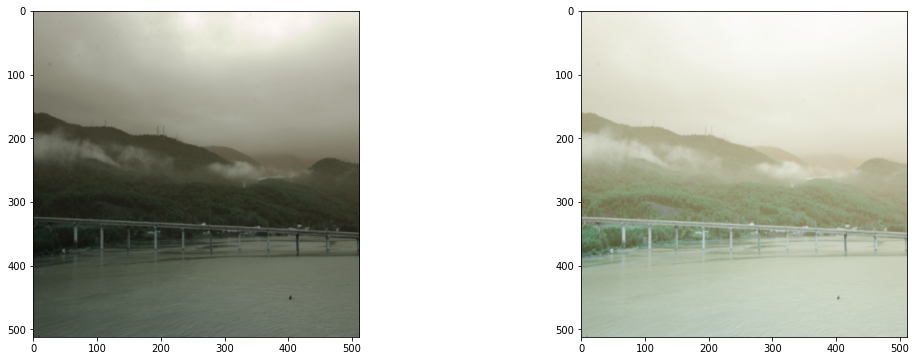

In [14]:
#Sanity check, view few images

SIZE=512
import random
import numpy as np
image_number = random.randint(0, len(X_train)-1)
print(image_number)
print("train")
print(len(X_train))
print("test")
print(len(X_test))
print("Validation")
print(len(x_val))
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.imshow(X_[image_number])
plt.subplot(122)
plt.imshow(y_[image_number])
plt.show()

In [15]:
# #PSNR LOSS
# def psnr(y_true, y_pred):
#     max_pixel = 1.0
#     return 10.0 * tf.math.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true)))) / tf.math.log(10.0)


In [16]:
def psnr_loss(y_true, y_pred):
    return -tf.image.psnr(y_true, y_pred, max_val=1.0)


In [17]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3),  kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = Dropout(0.10)(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = Dropout(0.10)(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = Dropout(0.10)(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3),  kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = Dropout(0.10)(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
#     c5 = Conv2D(1152, (3, 3),  kernel_initializer='he_normal', padding='same')(p4)
#     c5 = BatchNormalization()(c5)
#     c5 = Conv2D(1152, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
#     c5 = Dropout(0.30)(c5)
#     p5 = MaxPooling2D(pool_size=(2, 2))(c5)

    b1 = Conv2D(256, (3, 3),  kernel_initializer='he_normal', padding='same')(p4) 
    b1 = BatchNormalization()(b1)
    b1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(b1) 
    b1 = Dropout(0.10)(b1)
    
    #Expansive path 
#     u6 = Conv2DTranspose(1152, (2, 2), strides=(2, 2), padding='same')(b1)
#     u6 = concatenate([u6, c5])
#     c6 = Conv2D(1152, (3, 3),  kernel_initializer='he_normal', padding='same')(u6)
#     c6 = BatchNormalization()(c6)
#     c6 = Conv2D(1152, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
#     c6 = Dropout(0.30)(c6)
    
    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b1)
    u7 = concatenate([u7, c4])
    c7 = Conv2D(128, (3, 3),  kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = Dropout(0.10)(c7)
     
    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c3])
    c8 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = Dropout(0.10)(c8)
     
    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c2])
    c9 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = Dropout(0.10)(c9)
     
    u10 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c1], axis=3)
    c10 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(u10)
    c10 = BatchNormalization()(c10)
    c10 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
    c10 = Dropout(0.10)(c10)
     
    outputs = Conv2D(3, (3,3), activation='sigmoid', padding='same')(c10)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=psnr_loss, metrics=['accuracy'])
#     model.summary()
    
    return model

In [18]:
IMG_HEIGHT = X_.shape[1]
IMG_WIDTH  = X_.shape[2]
IMG_CHANNELS = X_.shape[3]

model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS)

2024-08-14 19:21:03.445978: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 19:21:03.884584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 23755 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capability: 8.0


In [19]:
#checkpoint = ModelCheckpoint('unet_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
tensorboard = TensorBoard(log_dir='./Arish/logs')
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
#callback = [checkpoint, reduce_lr, early_stopping, tensorboard]
callback = [tensorboard]

In [20]:
history = model.fit(X_train, y_train, batch_size = 16, verbose=1, epochs=100, validation_data=(x_val, y_val),callbacks=[callback], shuffle=False)

Epoch 1/100


2024-08-14 19:21:14.406566: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8303


57/57 [==============================] - 15s 164ms/step - loss: -16.2487 - accuracy: 0.5404 - val_loss: -8.3587 - val_accuracy: 0.5379
Epoch 2/100
57/57 [==============================] - 7s 128ms/step - loss: -17.9637 - accuracy: 0.6122 - val_loss: -12.7440 - val_accuracy: 0.6124
Epoch 3/100
57/57 [==============================] - 7s 128ms/step - loss: -18.4533 - accuracy: 0.6528 - val_loss: -13.5438 - val_accuracy: 0.6392
Epoch 4/100
57/57 [==============================] - 7s 128ms/step - loss: -18.7585 - accuracy: 0.6808 - val_loss: -14.1266 - val_accuracy: 0.6592
Epoch 5/100
57/57 [==============================] - 7s 128ms/step - loss: -18.9087 - accuracy: 0.6922 - val_loss: -16.2786 - val_accuracy: 0.6688
Epoch 6/100
57/57 [==============================] - 7s 128ms/step - loss: -19.0413 - accuracy: 0.6985 - val_loss: -16.9217 - val_accuracy: 0.6334
Epoch 7/100
57/57 [==============================] - 7s 129ms/step - loss: -19.1969 - accuracy: 0.6999 - val_loss: -18.1719 - val_

In [28]:
model.save('FinalModel.keras')

1/1 [==============================] - 1s 823ms/step - loss: -19.5809 - accuracy: 0.8525
Accuracy =  85.25436520576477 %


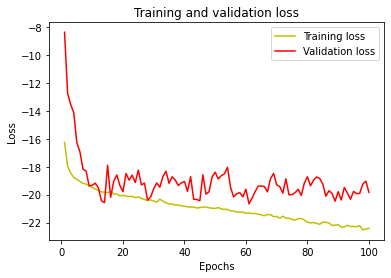

In [22]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

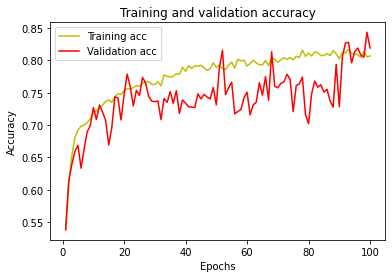

In [23]:
#acc = history.history['acc']
acc = history.history['accuracy']
#val_acc = history.history['val_acc']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
y_pred=model.predict(X_test)

intersection = np.logical_and(y_test, y_pred)
union = np.logical_or(y_test, y_pred)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)
y_pred_threshold=np.where(y_pred >= 0.5, 1, 0)
intersection_th = np.logical_and(y_test, y_pred_threshold)
union_th = np.logical_or(y_test, y_pred_threshold)
iou_score_th = np.sum(intersection_th) / np.sum(union_th)
print("IoU socre is: ", iou_score_th)
#print(intersection.any())

IoU socre is:  0.9985701243082682
IoU socre is:  0.6689312785119205


In [25]:
prediction = model.predict(X_test)

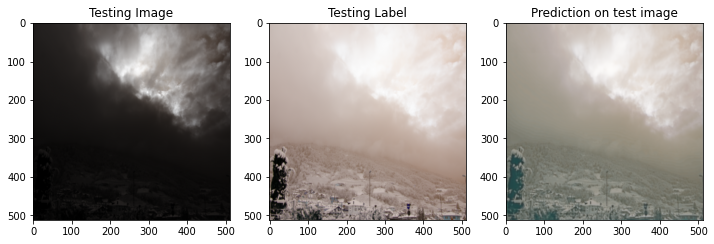

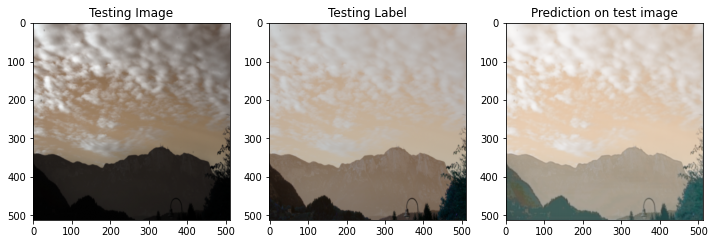

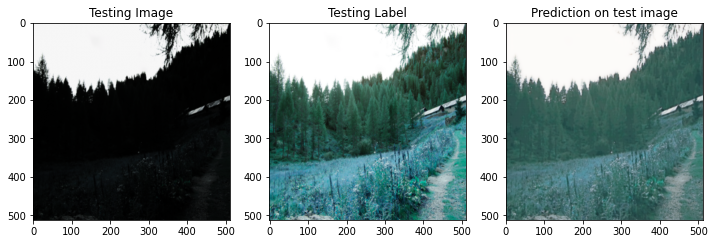

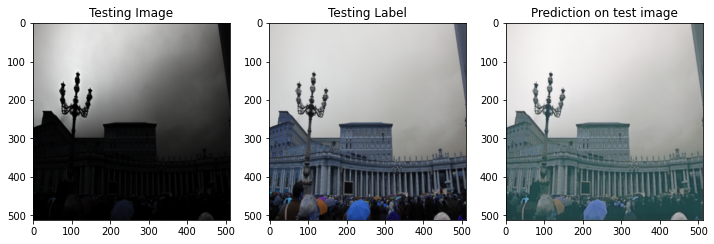

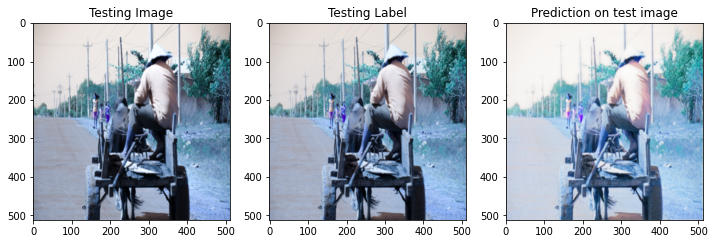

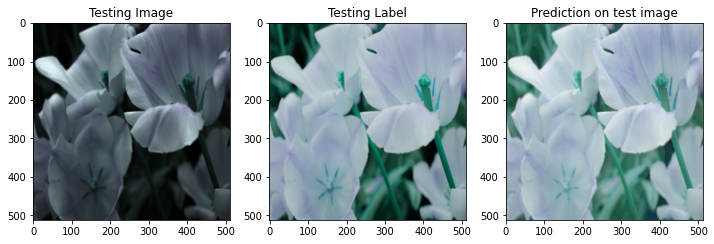

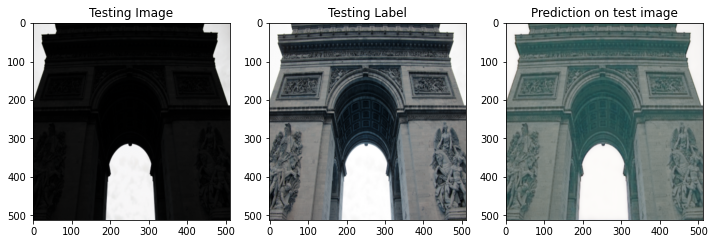

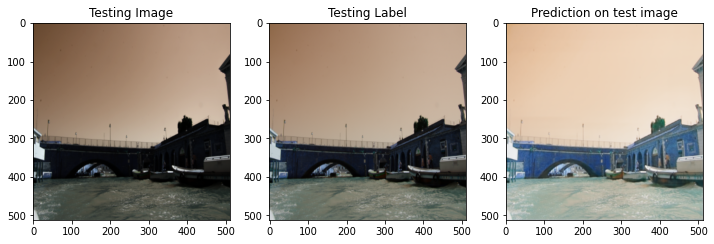

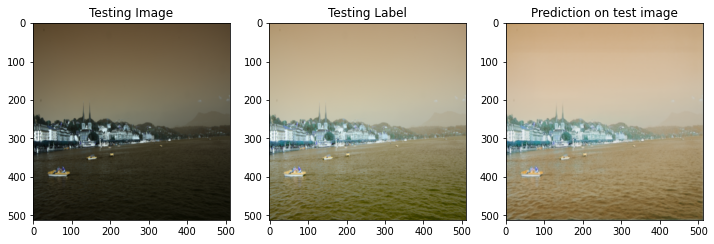

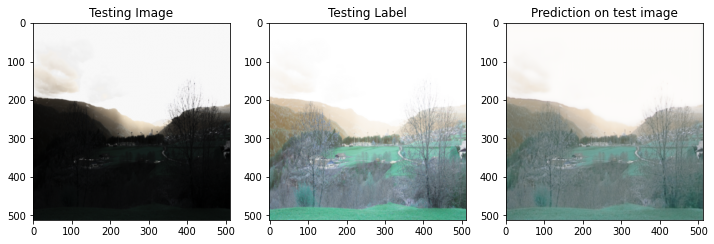

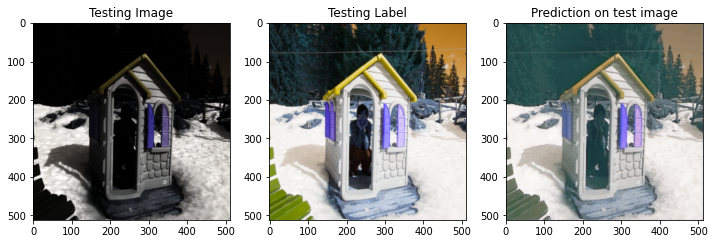

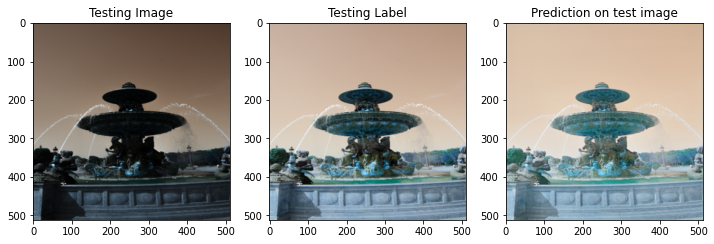

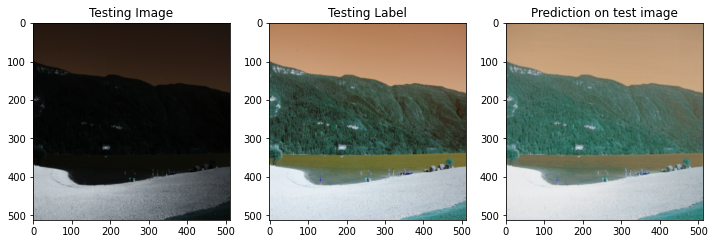

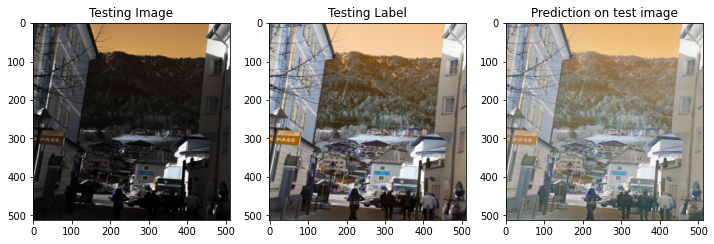

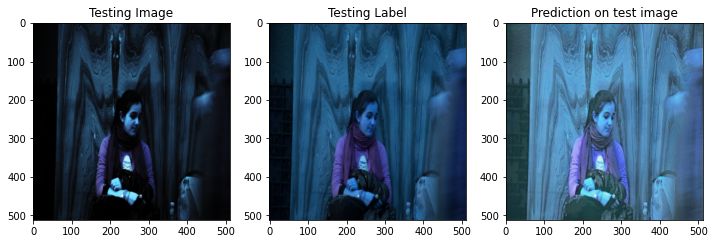

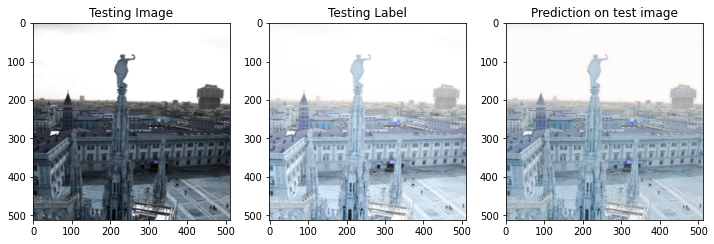

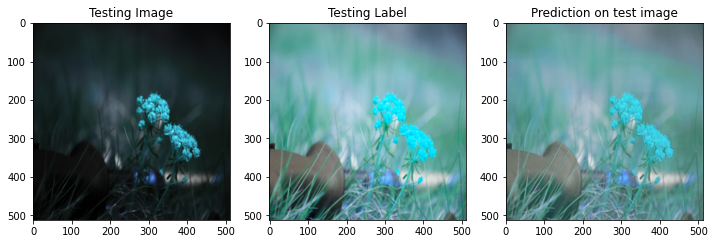

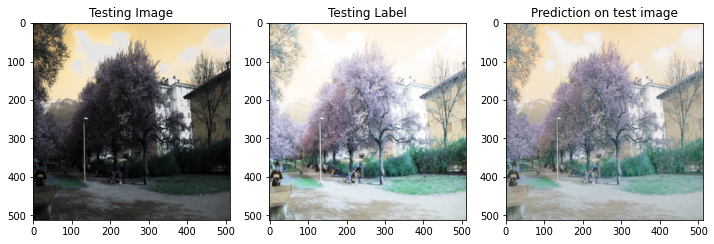

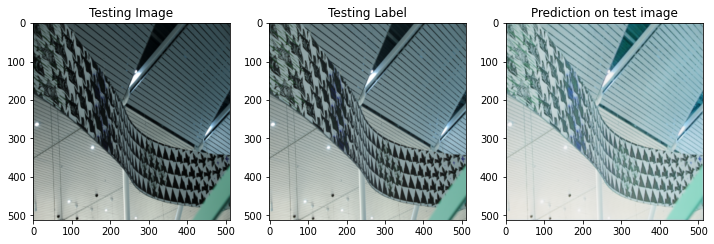

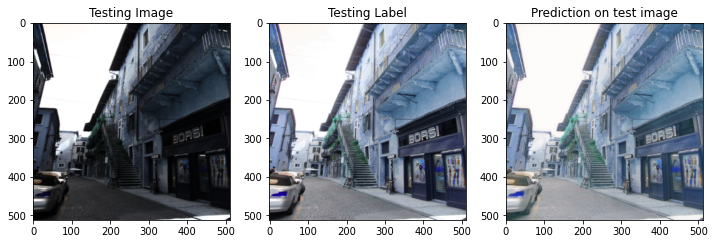

In [26]:
for i in range(len(X_test)):
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(X_test[i])
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(y_test[i])
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(prediction[i])